Trabalho de RN - Versao Adam

Aluno: Flávio Amorim

Número: 211100510

Turma: 2021.1

Ver github para obter versao mais atualizada


1) **Transfer learning é quando um modelo treinado em um conjunto de dados é utilizado para resolver um novo problema com dados diferentes daqueles que ele foi treinado.**


2) **Introdução:**



*   Modelo recebido como base do trabalho apresentava a seguinte performace:

  Loss: 0.08588726818561554      
  Accuracy: 0.9749000072479248


*   Modelo otimizado, usando otimizador Adam apresentou a seguinte performance:

  Loss: 0.04120932146906853
  
  Accuracy: 0.9932000041007996

3) **Melhorias aplicadas ao modelo recebido como base do trabalho:**
*   Criado uma estrutira de grid search para avaliar vários hiperparametros
*   Acrescentada a camada: layers.Dense(128, activation = 'relu')
*   Reduzido o dropout para: layers.Dropout(0.2)
*   Introduzida função de learning rate
*   Exibido as curvas de loss e acurácia para cada modelo treinado
*   Introduzida Funçào callback
*   Todos modelos treinamdo são salvos
*   Dataframe criado com as informações de hiperparametros e performance de cada modelo treinado
*   De acordo com este dataframe acima, o melhor modelo é carregado para uma nova uma predição na base de teste
*   Plotado algumas figuras resultantes da predição.


**4) Diversos cenários foram testados, mas nesse notebook estão apenas 04 cenários, incluindo o apresentou melhor performace e sem overfitting, que é:**

*   40 epochs
*   128 de batch size
*   0.1 de learning_rate
*   0.1 de decay
*   10% para validation_split

**Foi possível confirmar que o Adam, mesmo utilizando menos épocas, apresentou uma performance melhor do que o SGD.

A alteração do drop out para 0.2 representou uma melhora no modelo, embora o aumento do batch size para 256 não.
**

obs: Com a estrutura de grid search, diversos cenários foram testados, mas nesse notebook estão apenas alguns.


## Setup

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
import time

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint            # criados os checkpoints

In [ ]:
import tensorflow                                      # trabalhando com tensorflow # 2
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
print("TensorFlow version:", tensorflow.__version__)

TensorFlow version: 2.8.0


## Prepare the data

In [ ]:
# leitura dos dados
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# verificando o formato
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [ ]:
# criando um vetor com o nome das 10 classes
class_names = ['Zero','Um', 'Dois', 'Tres', 'Quatro', 'Cinco', 
               'Seis', 'Sete', 'Oito', 'Nove', 'Dez']

In [ ]:
### salvando o label em sua versao original antes de qualquer tratamento
y_test_clean = y_test

# Data Visualization

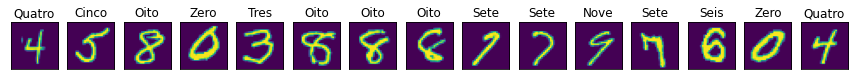

In [ ]:
# exibido randomicamente 15 imagens
# dados de treinamento

plt.figure(figsize=(15, 15))
for i in range(15):
    plt.subplot(1, 15, i + 1)
    #plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j = random.randint(1, len(x_train))
    plt.imshow(x_train[j].reshape((28,28)))
    label_index = int(y_train[j])
    plt.title(class_names[label_index])
plt.show()

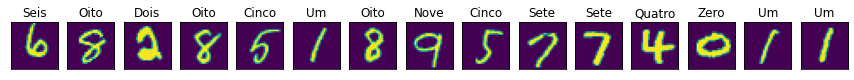

In [ ]:
# exibido randomicamente 15 imagens
# dados de teste

plt.figure(figsize=(15, 15))
for i in range(15):
    plt.subplot(1, 15, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j = random.randint(1, len(x_test))
    plt.imshow(x_test[j].reshape((28,28)))
    label_index = int(y_test[j])
    plt.title(class_names[label_index])
plt.show()

# Pre-processamento

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)               # imagens de 28 x 28 e profundidade 1 


# Scale images to the [0, 1] range      
x_train = x_train.astype("float32") / 255    # transformando para float e normalizando
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
# convert class vectors (labels) to binary class matrices (dim = 10 classes)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train.shape,y_test.shape)


(60000, 10) (10000, 10)


# Funcoes auxiliares

In [ ]:
# create a list of configs to try
def model_configs():
  # define scope of configs
  n_batch_size = [128,256]                      # foram feitos testes com 128 e 256
  n_epochs = [40,30]                            # foram feitos testes com 15, 25, 50, 60, 75 e 100
  n_validation_split = [0.1]                    # foram feitos testes com 0.1, 0.15, 0.2 e 0.3
  configs = list()                              # criado a lista com as combinações dos hiperparâmetros
  for i in n_batch_size:
    for j in n_epochs:
      for k in n_validation_split:
        cfg = [i, j, k]
        configs.append(cfg)
  print('Total configs: %d' % len(configs))
  return configs


In [ ]:
# plota a curva de loss e acurácia para teste e validação
def plota_figuras(history):
  fig = plt.figure(figsize=(10, 10))
  
  plt.subplot(2, 2, 1)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.legend()
  plt.title('Loss Function')

  plt.subplot(2, 2, 2)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.legend()
  plt.title('Accuracy')
  fig.savefig("fig01.png")

# Funcoes principais

Criada uma estrutura de grid search para executar vários treinamentos com diferentes modelos

In [ ]:
# cria o modelo, o otimizador, compila e faz o fit
def modelfit(cfg):
  #print(cfg)
  (n_batch_size, n_epochs, n_validation_split) = cfg

  model = keras.Sequential(
    [
      keras.Input(shape=input_shape),
      layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      layers.Dense(128, activation = 'relu'),
      layers.Dropout(0.2),
      layers.Dense(num_classes, activation="softmax"),
    ]
  )

  model.summary()

  adam = Adam(learning_rate=0.01, decay=0.01) 
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  filepath = "checkpoint-{epoch}.h5"
  checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]

  history = model.fit(x_train, y_train, batch_size=n_batch_size, epochs=n_epochs, validation_split=n_validation_split, callbacks=callbacks_list ) 

  return(history,model)

In [ ]:
# chama a funcao que cria o modelo e executa o fit
# executa o evaluate e depois salva o modelo
# exibe na tela os scores
def fit_evaluate_model(cfg,id_modelo):

  start = time.time()

  print('-------------------------new hiperparameter iteration---------------------------------------------')
  history,model = modelfit(cfg)

  end = time.time()
  plota_figuras(history)
  score = model.evaluate(x_test, y_test, verbose=0)
  print('\nSummary:')
  print('\nModelo: ',str(cfg))
  print('\nTime to Fit: ', end - start)
  print("Test loss:", score[0])
  print("Test accuracy:", score[1])
  print("Score:", score)
  filepath = f"model-{id_modelo}.h5"
  print("Salvando o modelo: ",filepath)
  model.save(filepath,overwrite=True,include_optimizer=True)  # creates a HDF5 file 'my_model.h5'
  print('\n\n\n')
  return (score[0],score[1])

In [ ]:
# executa o processamento para cada elemento da lista de hiperparametros
# retorna uma lista com os scores de cada modelo criado
def grid_search(cfg_list):
  scores = [fit_evaluate_model(cfg,id_modelo) for id_modelo,cfg in enumerate(cfg_list)]  # função executada para cada elemento da lista de hiperparâmetros
  return scores

# MAIN

In [ ]:
cfg_list = model_configs()
print('Configs: \n',cfg_list)

Total configs: 4
Configs: 
 [[128, 40, 0.1], [128, 30, 0.1], [256, 40, 0.1], [256, 30, 0.1]]


-------------------------new hiperparameter iteration---------------------------------------------
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1600)              0         
                     

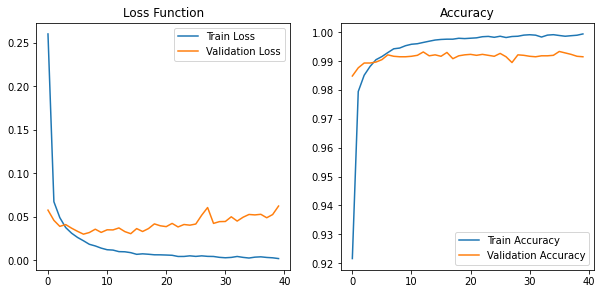

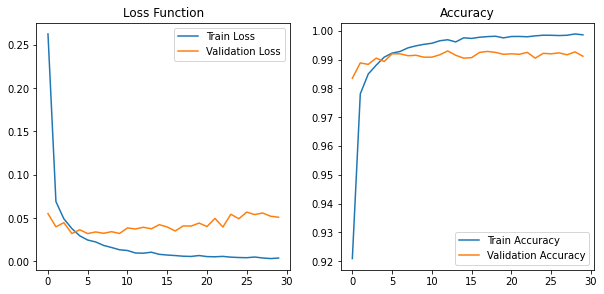

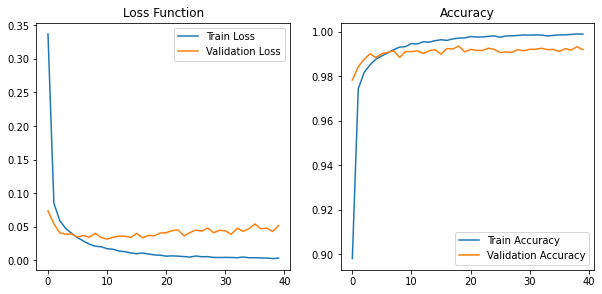

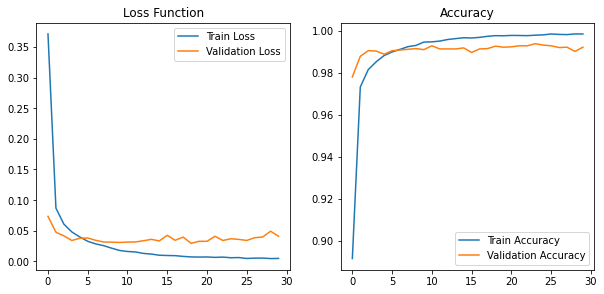

In [ ]:
# executa o modelo para a lista de hiperparâmetros definida em cfg_list
scores = grid_search(cfg_list)

In [ ]:
# exibe a lista de acuracia ordenada pela maior (melhor)
sorted(scores, key=lambda tup: tup[0])

[(0.03360705077648163, 0.992900013923645),
 (0.03576934337615967, 0.9921000003814697),
 (0.03718797117471695, 0.9925000071525574),
 (0.04120932146906853, 0.9932000041007996)]

In [ ]:
# cria um dataframe para registro do score de todos os modelos testados para futuro registro e comparação
import pandas as pd
lmodelo = []
lloss = []
laccuracy = []
lbatch_size = []                  # foram feitos testes com 128 e 256
lepochs = []                        # foram feitos testes com 15, 25, 50, 60, 75 e 100
lvalidation_split = [] 

dict = {}

for i in range(len(scores)):
  lmodelo.append(i)
  lloss.append(float(scores[i][0])) 
  laccuracy.append(float(scores[i][1]))
  lbatch_size .append(cfg_list[i][0])
  lepochs.append(cfg_list[i][1])
  lvalidation_split.append(cfg_list[i][2])
dict = {'Id Modelo':lmodelo,'Loss':lloss,'Accuracy':laccuracy,'Batch size':lbatch_size,'Epocs':lepochs,'Validation split':lvalidation_split}
df = pd.DataFrame(dict).sort_values(['Accuracy','Loss'],ascending=[False,True]).reset_index(drop=True)
df

,Id Modelo,Loss,Accuracy,Batch size,Epocs,Validation split
0,0,0.041209,0.9932,128,40,0.1
1,1,0.033607,0.9929,128,30,0.1
2,2,0.037188,0.9925,256,40,0.1
3,3,0.035769,0.9921,256,30,0.1


# Refazendo a predição para o conjunto de teste com o melhor modelo

In [ ]:
# Carrega o melhor modelo (considerado o com maior acurácia e menor loss)
id_best_model = df.iloc[0,0]
filepath = f'model-{id_best_model}.h5'
best_model = tensorflow.keras.models.load_model(
    filepath, custom_objects=None, compile=True, options=None)

best_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1600)              0         
                                                                 
 dense_8 (Dense)             (None, 128)              

# Predict e exibindo 15 registros aleatórios

In [ ]:
y_predict = best_model.predict(x_test)

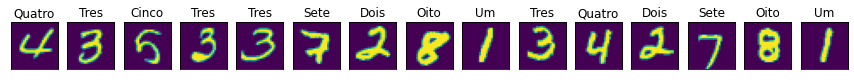

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(15):
    plt.subplot(1, 15, i + 1)
    #plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    j = random.randint(1, len(x_test))
    plt.imshow(x_test[j].reshape((28,28)))
    label_index = np.argmax(y_predict[j])     # argmax do elemento escolhido em y_predict
    plt.title(class_names[label_index])
plt.show()